In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pycorr 
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter


In [6]:
plt.style.use("astroandes.mplstyle")

In [7]:
def web_classification(n_data, n_random):
    assert len(n_data) == len(n_random)
    n_points = len(n_data)
    r_values = (n_data-n_random)/(n_data+n_random)
    web_class = np.zeros(n_points, dtype=int)
    lower_limit = -0.90
    upper_limit = 0.90
    is_void = r_values <= lower_limit
    is_sheet = (r_values > lower_limit) & (r_values<=0.0)
    is_filament = (r_values>0.0) & (r_values <= upper_limit)
    is_peak = (r_values > upper_limit)
    web_class[is_void] = 0
    web_class[is_sheet] = 1
    web_class[is_filament] = 2
    web_class[is_peak] = 3
    return web_class  

import numpy as np

def rotate_points_clockwise(X, Y, angle_degrees=135):
    """
    Rotate points (X, Y) clockwise around the origin by the specified angle.
    
    Parameters:
    -----------
    X, Y : numpy arrays or lists
        The x and y coordinates to rotate
    angle_degrees : float
        The angle in degrees to rotate clockwise
        
    Returns:
    --------
    X_rotated, Y_rotated : numpy arrays
        The rotated coordinates
    """
    # Convert angle to radians (positive for clockwise rotation)
    angle_radians = np.radians(angle_degrees)
    
    # Rotation matrix components
    cos_theta = np.cos(angle_radians)
    sin_theta = np.sin(angle_radians)
    
    # Apply rotation
    X_rotated = X * cos_theta + Y * sin_theta
    Y_rotated = -X * sin_theta + Y * cos_theta
    
    return X_rotated, Y_rotated

In [8]:
webs_data = {}
webs_random = {}
pos_data = {}
pos_random = {}

# TCW classification
tweb_data = np.loadtxt('../data/TCW/tcw_web/web_type_tweb.txt')
p_data = np.loadtxt('../data/TCW/pos/fof_catalog_200Mpc512_xyz.dat')
p_rand = np.loadtxt("../data/TCW/pos/random_000_fof_catalog_200Mpc512_xyz.dat")
hubble = 0.68
p_data = p_data[:,0:3]/hubble
p_rand = p_rand[:,0:3]/hubble
n_con_random = np.loadtxt("../data/TCW/web/random_000_fof_catalog_200Mpc512_xyz_fof_catalog_200Mpc512_xyz_nconnections.dat")
n_con_data = np.loadtxt("../data/TCW/web/fof_catalog_200Mpc512_xyz_random_000_fof_catalog_200Mpc512_xyz_nconnections.dat")
webs_data['TCW'] = web_classification(n_con_data[:,0], n_con_data[:,1])
webs_random['TCW'] = web_classification(n_con_random[:,0], n_con_random[:,1])
pos_data['TCW'] = p_data.copy()
pos_random['TCW'] = p_rand.copy()

# TNG classifications
p_data = np.loadtxt("../data/TNG/TNG300-1/pos/subhalo_massive_xyz.dat")
p_rand = np.loadtxt("../data/TNG/TNG300-1/pos/random_000_subhalo_massive_xyz.dat")
hubble=0.6774
p_data[:,0:3] = p_data[:,0:3]/1000.0/hubble
p_rand[:,0:3] = p_rand[:,0:3]/1000.0/hubble
n_con_random = np.loadtxt("../data/TNG/TNG300-1/web/random_000_subhalo_massive_xyz_subhalo_massive_xyz_nconnections.dat")
n_con_data = np.loadtxt("../data/TNG/TNG300-1/web/subhalo_massive_xyz_random_000_subhalo_massive_xyz_nconnections.dat")
webs_data['TNG'] = web_classification(n_con_data[:,0], n_con_data[:,1])
webs_random['TNG'] = web_classification(n_con_random[:,0], n_con_random[:,1])
pos_data['TNG'] = p_data.copy()
pos_random['TNG'] = p_rand.copy()

#SDSS classification
p_data = np.loadtxt("../data/SDSS/pos/mag_r_limited_xyz.dat")
p_rand = np.loadtxt("../data/SDSS/pos/random_000_mag_r_limited_xyz.dat")
p_data = p_data[:,0:3]
p_rand = p_rand[:,0:3]
p_data[:,0], p_data[:,1] = rotate_points_clockwise(p_data[:,0], p_data[:,1])
p_rand[:,0], p_rand[:,1] = rotate_points_clockwise(p_rand[:,0], p_rand[:,1])

n_con_random = np.loadtxt("../data/SDSS/web/random_000_mag_r_limited_xyz_mag_r_limited_xyz_nconnections.dat")
n_con_data = np.loadtxt("../data/SDSS/web/mag_r_limited_xyz_random_000_mag_r_limited_xyz_nconnections.dat")

webs_data['SDSS'] = web_classification(n_con_data[:,0], n_con_data[:,1])
webs_random['SDSS'] = web_classification(n_con_random[:,0], n_con_random[:,1])
pos_data['SDSS'] = p_data.copy()
pos_random['SDSS'] = p_rand.copy()

In [9]:

# Function to count fractions for random points
def count_web_fractions(web_classifications):
    """
    Count the fraction of points in each cosmic web type
    
    Parameters:
    -----------
    web_classifications : numpy array
        Array of web classifications (0=void, 1=sheet, 2=filament, 3=knot)
        
    Returns:
    --------
    fractions : dictionary
        Dictionary with the fraction of points in each web type
    """
    # Count total points
    total_points = len(web_classifications)
    
    # Count points in each category
    n_void = np.sum(web_classifications == 0)
    n_sheet = np.sum(web_classifications == 1)
    n_filament = np.sum(web_classifications == 2)
    n_knot = np.sum(web_classifications == 3)
    
    # Calculate fractions
    fractions = {
        'void': n_void / total_points * 100,
        'sheet': n_sheet / total_points * 100,
        'filament': n_filament / total_points * 100,
        'knot': n_knot / total_points * 100
    }
    
    return fractions

# Function to compute r values
def compute_r_values(n_data, n_random):
    """
    Compute the r parameter used for cosmic web classification.
    
    Parameters:
    -----------
    n_data : numpy array
        Number of connections to data points
    n_random : numpy array
        Number of connections to random points
        
    Returns:
    --------
    r_values : numpy array
        The computed r values: (n_data - n_random) / (n_data + n_random)
    """
    return (n_data - n_random) / (n_data + n_random)

# Function to plot r values histogram
def plot_r_values_histogram(r_values_dict, bins=19, figsize=(5, 3)):
    """
    Plot histogram of r_values for different datasets.
    
    Parameters:
    -----------
    r_values_dict : dict
        Dictionary with dataset names as keys and r_values arrays as values
    bins : int
        Number of bins for the histogram
    figsize : tuple
        Figure size (width, height)
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    linestyles = ['-', '--', '-.']
    
    for i, (dataset, r_values) in enumerate(r_values_dict.items()):
        # Calculate histogram
        hist, bin_edges = np.histogram(r_values, bins=bins, range=(-1, 1), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        # Plot histogram as line
        ax.plot(bin_centers, hist, label=dataset, color=colors[i % len(colors)],
                linestyle=linestyles[i % len(linestyles)], linewidth=2)
    
    # Add vertical lines for classification thresholds
    lower_limit = -0.90
    upper_limit = 0.90
    mid_point = 0.0
    
    #ax.axvline(x=lower_limit, color='gray', linestyle=':', alpha=0.7)
    #ax.axvline(x=mid_point, color='gray', linestyle=':', alpha=0.7)
    #ax.axvline(x=upper_limit, color='gray', linestyle=':', alpha=0.7)
    
    # Add text labels for the cosmic web types
    #ylim = ax.get_ylim()
    #text_y = ylim[1] * 0.9
    #ax.text((lower_limit - 1) / 2, text_y, "VOIDS", ha='center', fontsize=10)
    #ax.text((mid_point + lower_limit) / 2, text_y, "SHEETS", ha='center', fontsize=10)
    #ax.text((upper_limit + mid_point) / 2, text_y, "FILAMENTS", ha='center', fontsize=10)
    #ax.text((1 + upper_limit) / 2, text_y, "KNOTS", ha='center', fontsize=10)
    
    # Set plot properties
    ax.set_xlabel(r"$r$ = $\frac{N_\mathcal{O} - N_\mathcal{R}}{N_\mathcal{O} + N_\mathcal{R}}$", fontsize=20)
    ax.set_ylabel("PDF", fontsize=20)
    #ax.set_title("Distribution of r values across datasets", fontsize=14)
    ax.legend(fontsize=20,loc=2)
    #ax.grid(True, alpha=0.3)
    ax.set_xlim(-1, 1)
    plt.xlim([-1,1])
    # Format y-axis to remove scientific notation
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.savefig('r_values_histogram.pdf', dpi=300)
    plt.tight_layout()
    return fig, ax

Percentage of random points in each cosmic web type (Volume Filling Fraction):
       void  sheet  filament  knot
TCW    7.39  69.19     23.27  0.15
TNG   11.70  73.03     15.20  0.07
SDSS   6.89  72.64     20.28  0.19

Percentage of data points in each cosmic web type:
      void  sheet  filament   knot
TCW   0.26  36.44     60.11   3.20
TNG   0.38  31.27     50.73  17.62
SDSS  0.29  34.24     60.85   4.62

Comparison between data and random points distribution:

TCW Dataset:
 Data_void  Random_void  Data_sheet  Random_sheet  Data_filament  Random_filament  Data_knot  Random_knot
      0.26         7.39       36.44         69.19          60.11            23.27        3.2         0.15

TNG Dataset:
 Data_void  Random_void  Data_sheet  Random_sheet  Data_filament  Random_filament  Data_knot  Random_knot
      0.38         11.7       31.27         73.03          50.73             15.2      17.62         0.07

SDSS Dataset:
 Data_void  Random_void  Data_sheet  Random_sheet  Data_filament 

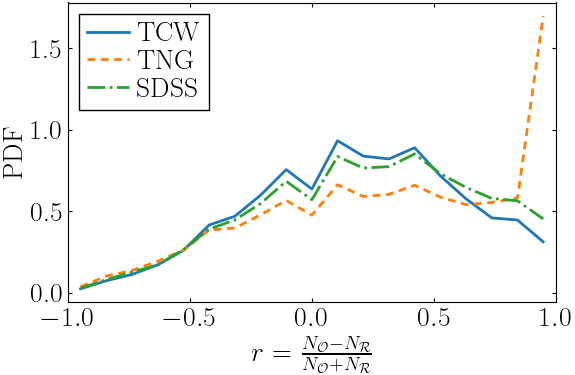

In [10]:
# ===================== EXECUTE ANALYSIS USING LOADED DATA =====================

# 1. Calculate web type fractions for random points
random_fractions = {}
for dataset in webs_random.keys():
    random_fractions[dataset] = count_web_fractions(webs_random[dataset])

# Create a DataFrame for better visualization
df_random = pd.DataFrame(random_fractions)
df_random_display = df_random.T

print("Percentage of random points in each cosmic web type (Volume Filling Fraction):")
print(df_random_display.round(2))

# 2. Calculate web type fractions for data points
data_fractions = {}
for dataset in webs_data.keys():
    data_fractions[dataset] = count_web_fractions(webs_data[dataset])

# Create a DataFrame for data points
df_data = pd.DataFrame(data_fractions)
df_data_display = df_data.T

print("\nPercentage of data points in each cosmic web type:")
print(df_data_display.round(2))

# 3. Compute r values for all datasets
r_values = {}
# TCW r values - using the already loaded n_con_data and n_con_random variables from the last dataset load
tcw_n_con_data = np.loadtxt("../data/TCW/web/fof_catalog_200Mpc512_xyz_random_000_fof_catalog_200Mpc512_xyz_nconnections.dat")
tcw_n_con_random = np.loadtxt("../data/TCW/web/random_000_fof_catalog_200Mpc512_xyz_fof_catalog_200Mpc512_xyz_nconnections.dat")
r_values['TCW'] = compute_r_values(tcw_n_con_data[:,0], tcw_n_con_data[:,1])

# TNG r values
tng_n_con_data = np.loadtxt("../data/TNG/TNG300-1/web/subhalo_massive_xyz_random_000_subhalo_massive_xyz_nconnections.dat")
tng_n_con_random = np.loadtxt("../data/TNG/TNG300-1/web/random_000_subhalo_massive_xyz_subhalo_massive_xyz_nconnections.dat")
r_values['TNG'] = compute_r_values(tng_n_con_data[:,0], tng_n_con_data[:,1])

# SDSS r values
sdss_n_con_data = np.loadtxt("../data/SDSS/web/mag_r_limited_xyz_random_000_mag_r_limited_xyz_nconnections.dat")
sdss_n_con_random = np.loadtxt("../data/SDSS/web/random_000_mag_r_limited_xyz_mag_r_limited_xyz_nconnections.dat")
r_values['SDSS'] = compute_r_values(sdss_n_con_data[:,0], sdss_n_con_data[:,1])

# 4. Plot the r values histogram
fig, ax = plot_r_values_histogram(r_values, figsize=(6, 4))


# 5. Create comparative table with both data and random distributions
print("\nComparison between data and random points distribution:")
for dataset in data_fractions.keys():
    print(f"\n{dataset} Dataset:")
    comparison = {
        'Data_void': data_fractions[dataset]['void'],
        'Random_void': random_fractions[dataset]['void'],
        'Data_sheet': data_fractions[dataset]['sheet'],
        'Random_sheet': random_fractions[dataset]['sheet'],
        'Data_filament': data_fractions[dataset]['filament'],
        'Random_filament': random_fractions[dataset]['filament'],
        'Data_knot': data_fractions[dataset]['knot'],
        'Random_knot': random_fractions[dataset]['knot']
    }
    df_compare = pd.DataFrame([comparison])
    print(df_compare.round(2).to_string(index=False))